In [57]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from sklearn.cluster import DBSCAN
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [8]:
#Задаём рабочую папку
os.chdir("/home/botiyava/learning/subjects/algo/lec3/eco228/")

In [19]:
#Читаем данные
df = pd.read_csv("Econom_Cities_data.csv", sep=";", index_col='City')
df.head()

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5


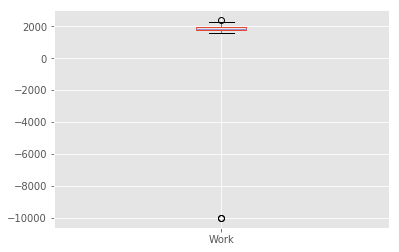

In [20]:
#Смортим есть ли выбросы в нашей выборке
plt.show(df.boxplot(column=['Work']))

In [22]:
#Выбросы обнаружены, они равны -9999. 
#Таких значений всего 2 и мы можем исключить
#Эти города из выборки, т.к. 2 показателя из 3
#в них не несут какой-либо информации
q = df['Work'].quantile(0.01)
Z = df[df['Work'] > q]


In [23]:
print(Z)

                Work  Price  Salary
City                               
Amsterdam       1714   65.6    49.0
Athens          1792   53.8    30.4
Bogota          2152   37.9    11.5
Bombay          2052   30.3     5.3
Brussels        1708   73.8    50.5
Buenos_Aires    1971   56.1    12.5
Caracas         2041   61.0    10.9
Chicago         1924   73.9    61.9
Copenhagen      1717   91.3    62.9
Dublin          1759   76.0    41.4
Dusseldorf      1693   78.5    60.2
Frankfurt       1650   74.5    60.4
Geneva          1880   95.9    90.3
Helsinki        1667  113.6    66.6
Hong_Kong       2375   63.8    27.8
Houston         1978   71.9    46.3
Johannesburg    1945   51.1    24.0
Kuala_Lumpur    2167   43.5     9.9
Lagos           1786   45.2     2.7
Lisbon          1742   56.2    18.8
London          1737   84.2    46.2
Los_Angeles     2068   79.8    65.2
Luxembourg      1768   71.1    71.1
Madrid          1710   93.8    50.0
Manila          2268   40.0     4.0
Mexico_City     1944   49.8 

In [24]:
#Стандартизируем данные, т.к. числа в 1 столбце намного больше чисел в остальных столбцах,
#но все столбцы одинакого значимы для нас.
from sklearn import preprocessing
norm = preprocessing.MinMaxScaler()
norm.fit(Z)
X = norm.transform(Z)

X = pd.DataFrame(X, index=Z.index, columns=Z.columns)

In [25]:
#Стандартизация прошла успешно
print(X)

                    Work     Price    Salary
City                                        
Amsterdam       0.165404  0.414319  0.475848
Athens          0.263889  0.275822  0.284687
Bogota          0.718434  0.089202  0.090442
Bombay          0.592172  0.000000  0.026721
Brussels        0.157828  0.510563  0.491264
Buenos_Aires    0.489899  0.302817  0.100719
Caracas         0.578283  0.360329  0.084275
Chicago         0.430556  0.511737  0.608428
Copenhagen      0.169192  0.715962  0.618705
Dublin          0.222222  0.536385  0.397739
Dusseldorf      0.138889  0.565728  0.590956
Frankfurt       0.084596  0.518779  0.593011
Geneva          0.375000  0.769953  0.900308
Helsinki        0.106061  0.977700  0.656732
Hong_Kong       1.000000  0.393192  0.257965
Houston         0.498737  0.488263  0.448099
Johannesburg    0.457071  0.244131  0.218911
Kuala_Lumpur    0.737374  0.154930  0.073998
Lagos           0.256313  0.174883  0.000000
Lisbon          0.200758  0.303991  0.165468
London    

In [26]:
#В начале проведем кластеризацию методом DBSCAN, 
#начальные параметры менять не будем ((eps=0.5, metric='euclidean', min_samples=5))
model = DBSCAN().fit(X)
clusters, members = np.unique(model.labels_, return_counts=True)
print(np.asarray((clusters, members)).T)

[[ 0 46]]


In [30]:
#кластеризация со стандартными значениями нас не устраивает,
#т.к. она по сути ничего не сделала.
#Поэтому будем менять параметры до тех пор, пока не увидим устраивающий нас результат.
#В данной попытке можно сказать что один огромный кластер, не устраивает.
model = DBSCAN(eps=0.25, min_samples=2).fit(X)
clusters, members = np.unique(model.labels_, return_counts=True)
print(np.asarray((clusters, members)).T)

[[-1  4]
 [ 0 38]
 [ 1  2]
 [ 2  2]]


In [78]:
#Уже лучше, но посмотрим еще
model = DBSCAN(eps=0.2, min_samples=2).fit(X)
clusters, members = np.unique(model.labels_, return_counts=True)
print(np.asarray((clusters, members)).T)

[[-1  8]
 [ 0 19]
 [ 1 19]]


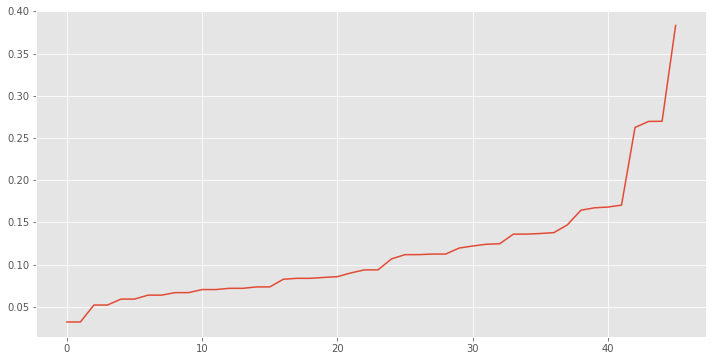

In [70]:
#смотрим на оптимальные значения эпсилон
#как мы видим всё же 0.2 это хорошее значение для нас, значение ~27 нас не устраивает, т.к. там 
#всё сливается в один большой кластер.
plt.figure(figsize=(12,6))
nn = NearestNeighbors(n_neighbors=2).fit(X)
distances, idx = nn.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [89]:
model = DBSCAN(eps=0.2, min_samples=3).fit(X)
clusters, members = np.unique(model.labels_, return_counts=True)
print(np.asarray((clusters, members)).T)

[[-1  8]
 [ 0 19]
 [ 1 19]]


In [91]:
#Посмотрим на средние показатели полученных групп. 
#Что мы тут видим? первая строка - это выбросы. сюда попали слишком развитые города и столицы некоторых стран.
#В нулевом кластере находятся богатые города, в которых работают меньше, чем в первом кластере, получают больше, но
# и цены выше. Всё логично.
#В первый кластер попали бедные страны. Работают тут больше, чем в богатых городах, а получают в разы меньше, цены,
#соответственно, тоже ниже.
X['dbscan'] = model.labels_
X.groupby('dbscan').mean()

,Work,Price,Salary
dbscan,,,
-1,0.400726,0.817195,0.601876
0,0.263889,0.554299,0.539136
1,0.475013,0.232580,0.124249


In [93]:
print(X)

                    Work     Price    Salary  dbscan
City                                                
Amsterdam       0.165404  0.414319  0.475848       0
Athens          0.263889  0.275822  0.284687       1
Bogota          0.718434  0.089202  0.090442       1
Bombay          0.592172  0.000000  0.026721       1
Brussels        0.157828  0.510563  0.491264       0
Buenos_Aires    0.489899  0.302817  0.100719       1
Caracas         0.578283  0.360329  0.084275       1
Chicago         0.430556  0.511737  0.608428       0
Copenhagen      0.169192  0.715962  0.618705       0
Dublin          0.222222  0.536385  0.397739       0
Dusseldorf      0.138889  0.565728  0.590956       0
Frankfurt       0.084596  0.518779  0.593011       0
Geneva          0.375000  0.769953  0.900308      -1
Helsinki        0.106061  0.977700  0.656732      -1
Hong_Kong       1.000000  0.393192  0.257965      -1
Houston         0.498737  0.488263  0.448099       0
Johannesburg    0.457071  0.244131  0.218911  

# Интерпретация кластеров
## В результате моего анализа я получил 2 кластера и 8 выбросов. 
## 1. 8 выбросов представляют собой очень развитые города, который настолько развиты, что их нельзя отнести к просто развитым в экономическом плане городам. Тут, в основном, находятся высокоразвитые центры стран.
## 2. Далее следуют экономически развитые города (тут находятся многие города США, Европы и Австралии).
## 3. В последнем кластере находятся города с плохим экономическим развитием (низкие зарплаты и цены в магазинах, больше рабочих часов).